In [1]:
import quadrocoptertrajectory as quadtraj

In [3]:
print(quadtraj)

<module 'quadrocoptertrajectory' from '/home/henry/Documents/ap-sim/ac-dev/control/design/src/RapidQuadrocopterTrajectories/quadrocoptertrajectory.py'>


Axis # 0
	alpha =  720.0 	beta =  -360.0 	gamma =  60.0
Axis # 1
	alpha =  588.6 	beta =  -235.44 	gamma =  29.43
Axis # 2
	alpha =  -1080.0 	beta =  528.0 	gamma =  -84.0
Total cost =  3218.1249000000025
Input feasibility result:  Feasible ( 0 )
Position feasibility result:  Feasible ( 0 )


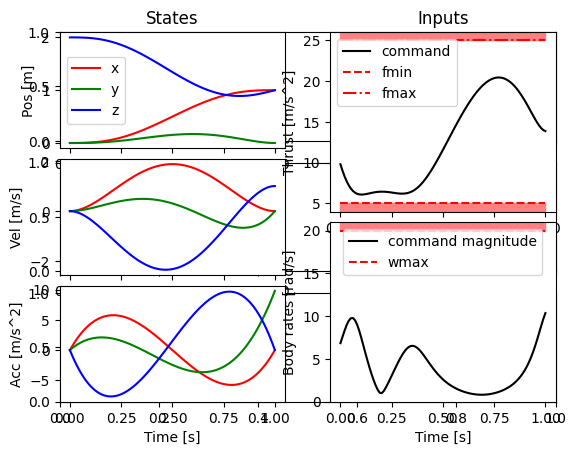

In [22]:
# Define the trajectory starting state:
pos0 = [0, 0, 2] #position
vel0 = [0, 0, 0] #velocity
acc0 = [0, 0, 0] #acceleration

# Define the goal state:
posf = [1, 0, 1]  # position
velf = [0, 0, 1]  # velocity
accf = [0, 9.81, 0]  # acceleration

# Define the duration:
Tf = 1

# Define the input limits:
fmin = 5  #[m/s**2]
fmax = 25 #[m/s**2]
wmax = 20 #[rad/s]
minTimeSec = 0.02 #[s]

# Define how gravity lies:
gravity = [0,0,-9.81]
 
traj = quadtraj.RapidTrajectory(pos0, vel0, acc0, gravity)
traj.set_goal_position(posf)
traj.set_goal_velocity(velf)
traj.set_goal_acceleration(accf)

# Note: if you'd like to leave some states free, there are two options to 
# encode this. As exmample, we will be leaving the velocity in `x` (axis 0)
# free:
#
# Option 1: 
# traj.set_goal_velocity_in_axis(1,velf_y);
# traj.set_goal_velocity_in_axis(2,velf_z);
# 
# Option 2:
# traj.set_goal_velocity([None, velf_y, velf_z])
 
# Run the algorithm, and generate the trajectory.
traj.generate(Tf)

# Test input feasibility
inputsFeasible = traj.check_input_feasibility(fmin, fmax, wmax, minTimeSec)

# Test whether we fly into the floor
floorPoint  = [0,0,0]  # a point on the floor
floorNormal = [0,0,1]  # we want to be in this direction of the point (upwards)
positionFeasible = traj.check_position_feasibility(floorPoint, floorNormal)
 
for i in range(3):
    print("Axis #" , i)
    print("\talpha = " ,traj.get_param_alpha(i), "\tbeta = "  ,traj.get_param_beta(i), "\tgamma = " ,traj.get_param_gamma(i))
print("Total cost = " , traj.get_cost())
print("Input feasibility result: ",    quadtraj.InputFeasibilityResult.to_string(inputsFeasible),   "(", inputsFeasible, ")")
print("Position feasibility result: ", quadtraj.StateFeasibilityResult.to_string(positionFeasible), "(", positionFeasible, ")")

###########################################
# Plot the trajectories, and their inputs #
###########################################

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

numPlotPoints = 100
time = np.linspace(0, Tf, numPlotPoints)
position = np.zeros([numPlotPoints, 3])
velocity = np.zeros([numPlotPoints, 3])
acceleration = np.zeros([numPlotPoints, 3])
thrust = np.zeros([numPlotPoints, 1])
ratesMagn = np.zeros([numPlotPoints,1])

for i in range(numPlotPoints):
    t = time[i]
    position[i, :] = traj.get_position(t)
    velocity[i, :] = traj.get_velocity(t)
    acceleration[i, :] = traj.get_acceleration(t)
    thrust[i] = traj.get_thrust(t)
    ratesMagn[i] = np.linalg.norm(traj.get_body_rates(t))

figStates, axes = plt.subplots(3,1,sharex=True)
gs = gridspec.GridSpec(6, 2)
axPos = plt.subplot(gs[0:2, 0])
axVel = plt.subplot(gs[2:4, 0])
axAcc = plt.subplot(gs[4:6, 0])

for ax,yvals in zip([axPos, axVel, axAcc], [position,velocity,acceleration]):
    cols = ['r','g','b']
    labs = ['x','y','z']
    for i in range(3):
        ax.plot(time,yvals[:,i],cols[i],label=labs[i])

axPos.set_ylabel('Pos [m]')
axVel.set_ylabel('Vel [m/s]')
axAcc.set_ylabel('Acc [m/s^2]')
axAcc.set_xlabel('Time [s]')
axPos.legend()
axPos.set_title('States')

infeasibleAreaColour = [1,0.5,0.5]
axThrust = plt.subplot(gs[0:3, 1])
axOmega  = plt.subplot(gs[3:6, 1])
axThrust.plot(time,thrust,'k', label='command')
axThrust.plot([0,Tf],[fmin,fmin],'r--', label='fmin')
axThrust.fill_between([0,Tf],[fmin,fmin],-1000,facecolor=infeasibleAreaColour, color=infeasibleAreaColour)
axThrust.fill_between([0,Tf],[fmax,fmax], 1000,facecolor=infeasibleAreaColour, color=infeasibleAreaColour)
axThrust.plot([0,Tf],[fmax,fmax],'r-.', label='fmax')

axThrust.set_ylabel('Thrust [m/s^2]')
axThrust.legend()

axOmega.plot(time, ratesMagn,'k',label='command magnitude')
axOmega.plot([0,Tf],[wmax,wmax],'r--', label='wmax')
axOmega.fill_between([0,Tf],[wmax,wmax], 1000,facecolor=infeasibleAreaColour, color=infeasibleAreaColour)
axOmega.set_xlabel('Time [s]')
axOmega.set_ylabel('Body rates [rad/s]')
axOmega.legend()

axThrust.set_title('Inputs')

#make the limits pretty:
axThrust.set_ylim([min(fmin-1,min(thrust)), max(fmax+1,max(thrust))])
axOmega.set_ylim([0, max(wmax+1,max(ratesMagn))])

plt.show()
